# Char RNN

En esta notebook, haremos un clasificador en base a caracteres



In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import csv

df_dev = pd.read_table("../../../data/es/dev_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_train = pd.read_table("../../../data/es/train_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)

text_train, y_train = df_train["text"], df_train["HS"]
text_dev, y_dev = df_dev["text"], df_dev["HS"]

print("Instancias de entrenamiento: {}".format(len(df_train)))
print("Instancias de desarrollo: {}".format(len(df_dev)))




Instancias de entrenamiento: 4500
Instancias de desarrollo: 500


Primero, entrenemos una LSTM para caracteres

In [2]:
from hate.nn import Tokenizer
tokenize_args = {
    "preserve_case": False, 
    "deaccent": True,
    "reduce_len": True, 
    "strip_handles": False,
    "stem": True,
    "alpha_only": False
}

tokenizer = Tokenizer(**tokenize_args)

text_train = [" ".join(tokenizer.tokenize(t)) for t in df_train["text"].values]
text_dev = [" ".join(tokenizer.tokenize(t)) for t in df_dev["text"].values]



Using TensorFlow backend.


Probemos haciendo stemming primero

In [3]:
from keras.preprocessing.text import Tokenizer as KerasTokenizer

vocab_size = 200
char_tokenizer = KerasTokenizer(num_words=vocab_size, char_level=True, 
                           lower=tokenize_args["preserve_case"])
char_tokenizer.fit_on_texts(text_train)

char_train = char_tokenizer.texts_to_sequences(text_train)
char_dev = char_tokenizer.texts_to_sequences(text_dev)

In [4]:
print("Cantidad de tokens total: {}".format(len(char_tokenizer.word_index)))
print("Nos quedamos con {}".format(vocab_size))

Cantidad de tokens total: 320
Nos quedamos con 200


Hagamos un histograma de la cantidad de caracteres primero


(array([358., 909., 892., 800., 492., 273., 257., 264., 220.,  35.]),
 array([  5. ,  32.1,  59.2,  86.3, 113.4, 140.5, 167.6, 194.7, 221.8,
        248.9, 276. ]),
 <a list of 10 Patch objects>)

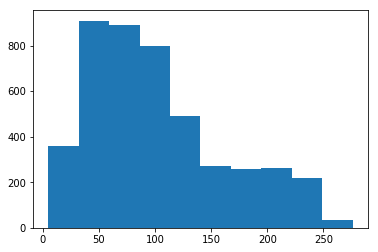

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist([len(t) for t in text_train])

Cortemos en 250

In [6]:
import numpy as np

max_charlen = 250


Hagamos un primer modelo con múltiple inputs.

In [7]:
from hate.nn import CharModel
from keras.optimizers import Adam
from keras.layers import CuDNNLSTM

optimizer_args = {
    "lr": 0.001,
    "decay": 0.001,
}

embedding_dim = 150


model = CharModel(vocab_size=vocab_size, max_charlen=max_charlen, 
                  tokenize_args=tokenize_args, recursive_class=CuDNNLSTM)
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])

model.fit(text_train, y_train, validation_data=(text_dev, y_dev), epochs=15, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/15
4500/4500 [==============================] - 4s 1000us/step - loss: 0.6805 - acc: 0.5767 - val_loss: 0.6833 - val_acc: 0.5840
Epoch 2/15
4500/4500 [==============================] - 2s 525us/step - loss: 0.6556 - acc: 0.6282 - val_loss: 0.6499 - val_acc: 0.6260
Epoch 3/15
4500/4500 [==============================] - 2s 524us/step - loss: 0.6215 - acc: 0.6749 - val_loss: 0.6245 - val_acc: 0.6280
Epoch 4/15
4500/4500 [==============================] - 2s 521us/step - loss: 0.5583 - acc: 0.7200 - val_loss: 0.6162 - val_acc: 0.6900
Epoch 5/15
4500/4500 [==============================] - 2s 527us/step - loss: 0.5246 - acc: 0.7509 - val_loss: 0.5777 - val_acc: 0.7140
Epoch 6/15
4500/4500 [==============================] - 2s 528us/step - loss: 0.4815 - acc: 0.7853 - val_loss: 0.5622 - val_acc: 0.7340
Epoch 7/15
4500/4500 [==============================] - 2s 529us/step - loss: 0.4628 - acc: 0.7993 - val_loss: 0.5898 - val_acc: 0.7320


In [8]:
from hate.utils import print_evaluation

print_evaluation(model, text_dev, y_dev)

500/500 [==============================] - 0s 165us/step
Loss        : 0.8054
Accuracy    : 0.7260
Precision   : 0.7457
Recall      : 0.5811
F1          : 0.6532


No parece mejorar mucho stemming

## Error Analysis

Vamos a ver los tweets con mayores errores

In [10]:
df_dev["proba"] = model.predict(text_dev)


true_positives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] >= 0.5)].copy()
true_negatives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] < 0.5)].copy()

false_positives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] > 0.5)].copy()
false_positives.sort_values("proba", ascending=False, inplace=True)


false_negatives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] < 0.5)].copy()
false_negatives.sort_values("proba", ascending=True, inplace=True)

conf_matrix = pd.DataFrame([
    {"real":"hs=1", "pred_true": len(true_positives), "pred_false": len(false_negatives)},
    {"real":"hs=0", "pred_true": len(false_positives), "pred_false": len(true_negatives)}
])



conf_matrix.set_index("real", inplace=True)

print("Falsos negativos: {}".format(len(false_negatives)))
print("Falsos positivos: {}".format(len(false_positives)))

conf_matrix[["pred_true", "pred_false"]]

Falsos negativos: 93
Falsos positivos: 44


,pred_true,pred_false
real,,
hs=1,129,93
hs=0,44,234


## Falsos Negativos

Veamos los 20 falsos negativos en los cuales nuestro modelo se equivoca más

In [11]:
pd.set_option('max_colwidth', 300)

false_negatives[["text", "proba"]]


,text,proba
id,,
24746,@rU_1970 muestra como teni esa vagina de puta caliente llena de moco wacha culia hija de la perra traga semen 146:146,8.089439e-07
23396,Habeis visto el video de la señora del Metro de Madrid que no deja sentar a una niña extranjera??? pues el vídeo de los negratas pegando a un turista americano por defender a una mujer con una silla de un bebé en Barcelona no lo vais a ver!! #👏👏👏👏👏,4.412056e-05
24488,Un indocumentado...habla y habla y no para y acaba hablando su ignorancia.Empezamos bien. https://t.co/SMRsqjtEBT,1.006962e-03
21297,@valevitarb es que tú eres LA perra MAYOR 🐕✨✨✨✨✨,2.904902e-03
20063,"@AnderssonBoscan Vieja zorra imbécil y MENTIROSA, que nos cree unos solemnes cojudos. Señor Lenin, por favor dignifique al Ecuador, pobres, pero no en la cloaca robolucionaria!!",5.122448e-03
23716,"- El otro día me comí a Laura es muy fácil que guarra jajajaja - Laura también te comió a ti entonces tú eres igual de guarro e igual de fácil. - Puto feminazi putas modas eres feminista solo para ligar bien queda gilipollas - em, ok",5.806657e-03
24352,"¿Ves que tu coño me importe? Cómete mi polla, basura https://t.co/ht02KyYWZh",8.303330e-03
20652,"@Dselenaaaa callate zorra seguro fue para uno de tus 9174829283 chicos, pero no importa porque a mi me amas mas y seguro extrañas mis abrazos, fin.",9.315151e-03
23922,Pobre moromierda. Pues a mi me parece mas digna y respetable la vida de una linda gallina que acabará en un KFC que ése semita culturizado en el país de la violación que acaban de dejar libre https://t.co/lrL1K09aIb,1.044602e-02


## Elmo y OOV words

# Conclusiones

Sirvió mejorar el preprocesamiento. Quedamos en pérdida ~0.43

No estarían convenciendo las traducciones...

Diría que intentemos un ensemble con caracteres o n-gramas.